**Read Existing Data Utility**

Use this notebook to read in existing data from a vessel into a seafloor model file. 

In the cell below please enter the required parameters and data filenames.

In [1]:
# Input data file names
vesselA_data_file = 'data/yohoA.csv'
vesselB_data_file = 'data/yohoB.csv'

# Input seafloor model file names
vesselA_model_file = 'output/vA_model_yoho.nc'
vesselB_model_file = 'output/vB_model_yoho.nc'

# Output seafloor model file names
vesselA_output_file = 'output/vA_model_filled_yoho.nc'
vesselB_output_file = 'output/vB_model_filled_yoho.nc'

Import Libraries

In [2]:
from datetime import datetime as dt
import serial
import pynmea2
import xarray as xr
import csv

import geopandas
from shapely.geometry import Point, box
import pyproj
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point
from shapely.ops import transform
import pandas as pd
from shapely.geometry import Polygon
import numpy as np
from shapely.prepared import prep
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import math

Import the vessel model files into xarrays and pull out relavent metadata

In [4]:
# Open the data models for each vessel
vA = xr.open_dataset(vesselA_model_file)
vB = xr.open_dataset(vesselB_model_file)

# Pull out attributes for survey as a whole and for each vessel for easy use
home_point = vA.attrs['home_point']
away_point = vA.attrs['away_point']
allow_sigmaVert = vA.attrs['allowable_sigmaVertical']
input_geodetics = 'EPSG:4326'                               
project_geodetics = 'EPSG:32619' 

vA_sigmaVert = vA.attrs['vesselA_sigmaVertical']
vA_sigmaHor = vA.attrs['vesselA_sigmaHorizontal']
vA_min_safe_depth = vA.attrs['vesselA_min_safe_depth']

vB_sigmaVert = vB.attrs['vesselB_sigmaVertical']
vB_sigmaHor = vB.attrs['vesselB_sigmaHorizontal']
vB_min_safe_depth = vB.attrs['vesselB_min_safe_depth']

Initialize functions for calculating running variance and initialize the geodetic transform.

In [5]:
# For a new value new_value, compute the new count, new mean, the new M2.
# mean accumulates the mean of the entire dataset
# M2 aggregates the squared distance from the mean
# count aggregates the number of samples seen so far
def update(existing_aggregate, new_value):
    (count, mean, M2) = existing_aggregate
    count += 1
    delta = new_value - mean
    mean += delta / count
    delta2 = new_value - mean
    M2 += delta * delta2
    return (count, mean, M2)

# Retrieve the mean, variance and sample variance from an aggregate
def finalize(existing_aggregate):
    (count, mean, M2) = existing_aggregate
    if count < 2:
        return float("nan")
    else:
        (mean, variance, sample_variance) = (mean, M2 / count, M2 / (count - 1))
        return (mean, variance, sample_variance)
    
wgs84 = pyproj.CRS(input_geodetics)
utm = pyproj.CRS(project_geodetics)

projection = pyproj.Transformer.from_crs(wgs84, utm, always_xy=True).transform

Initialize a function for reading the data in for the vessels.

In [6]:
def read_existing_data(vessel_data_file, vDS, vessel, home, away, projection):
    with open(vessel_data_file) as csv_file:
        csv_reader = csv.reader(csv_file)
        
        for row in csv_reader:
            lat = float(row[2])
            long = float(row[3])
            depth = float(row[4])
            
            coords = transform(projection, Point([long, lat]))
            north = coords.y
            east = coords.x
            
            north = round(north - home[1])
            east = round(east - home[0])
            
            try:
                if np.isnan(vDS['soundings'].loc[dict(north=north, east=east, vessel=vessel)]):
                    vDS['depth'].loc[dict(north=north, east=east, vessel=vessel)] = depth
                    vDS['soundings'].loc[dict(north=north, east=east, vessel=vessel)] = 1
                    vDS['M2'].loc[dict(north=north, east=east, vessel=vessel)] = 0
                    vDS['stdev'].loc[dict(north=north, east=east, vessel=vessel)] = 0

                else:
                    prev_soundings = vDS['soundings'].loc[dict(north=north, east=east, vessel=vessel)]
                    prev_depth = vDS['depth'].loc[dict(north=north, east=east, vessel=vessel)]
                    prev_M2 = vDS['M2'].loc[dict(north=north, east=east, vessel=vessel)]

                    updates = update((prev_soundings, prev_depth, prev_M2), depth)
                    finals = finalize(updates)

                    vDS['depth'].loc[dict(north=north, east=east, vessel=vessel)] = updates[1]
                    vDS['soundings'].loc[dict(north=north, east=east, vessel=vessel)] = updates[0]
                    vDS['M2'].loc[dict(north=north, east=east, vessel=vessel)] = updates[2]
                    vDS['stdev'].loc[dict(north=north, east=east, vessel=vessel)] = math.sqrt(finals[1])
            except:
                pass

    return vDS

Experimental After this point

In [7]:
vA = read_existing_data(vesselA_data_file, vA, 'A', home_point, away_point, projection)

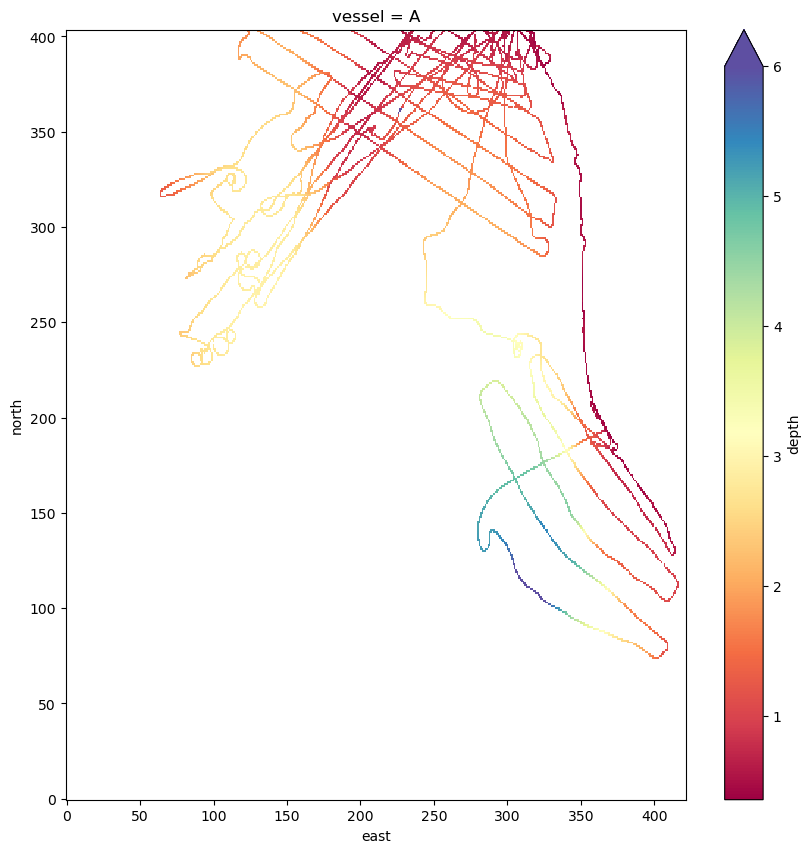

In [8]:
vA.depth.sel(vessel='A').plot(figsize=(10,10), vmax=6, cmap='Spectral')

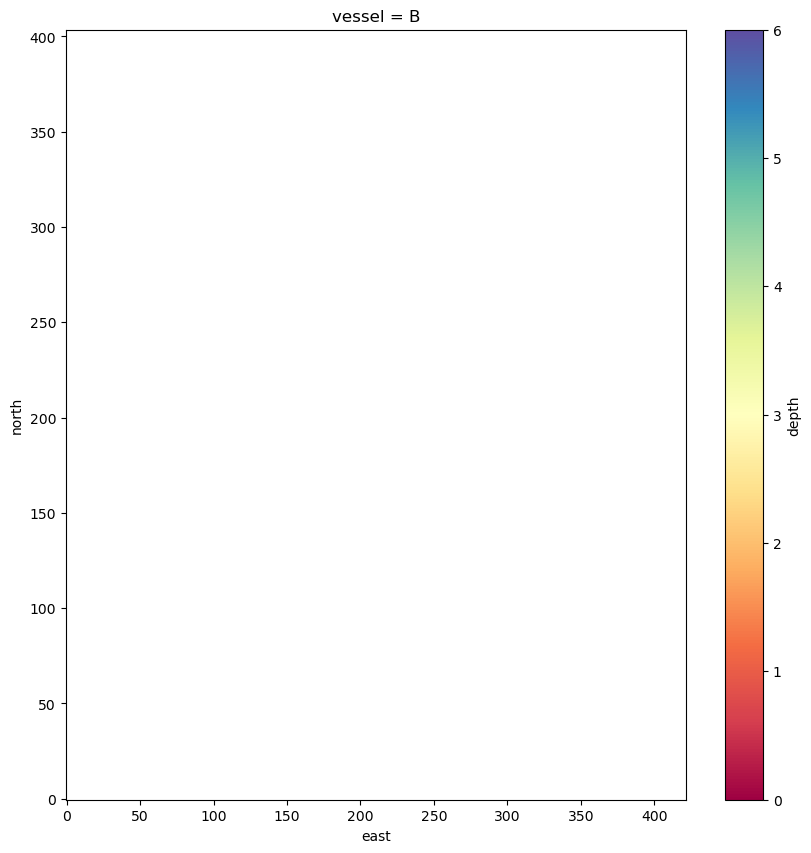

In [9]:
vA.depth.sel(vessel='B').plot(figsize=(10,10), vmax=6, cmap='Spectral')

In [10]:
vB = read_existing_data(vesselB_data_file, vB, 'B', home_point, away_point, projection)

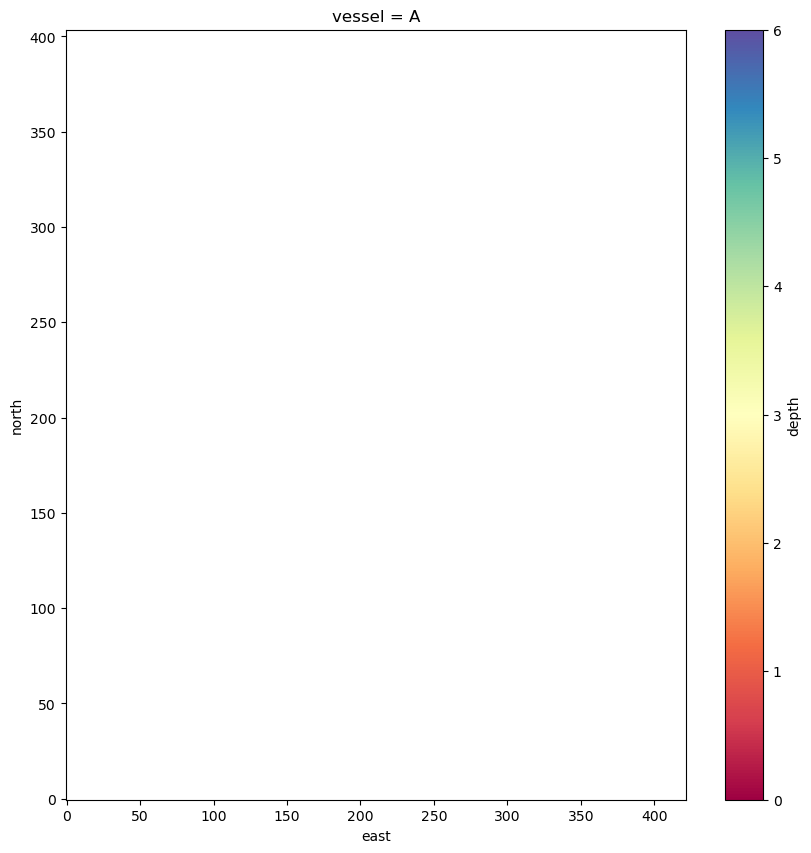

In [11]:
vB.depth.sel(vessel='A').plot(figsize=(10,10), vmax=6, cmap='Spectral')

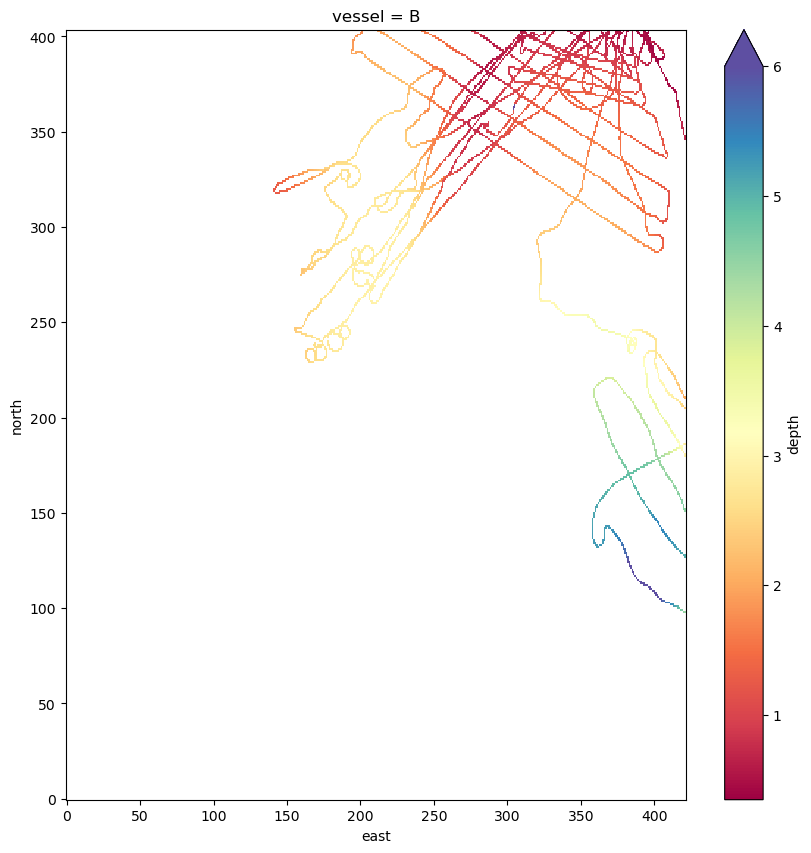

In [12]:
vB.depth.sel(vessel='B').plot(figsize=(10,10), vmax=6, cmap='Spectral')

In [13]:
vA.to_netcdf(path=vesselA_output_file)
vB.to_netcdf(path=vesselB_output_file)

In [14]:
vA2 = xr.open_dataset(vesselA_output_file)
vB2 = xr.open_dataset(vesselB_output_file)

In [27]:
vA2['depth'].loc[dict(vessel='B')] = vB2['depth'].loc[dict(vessel='B')]

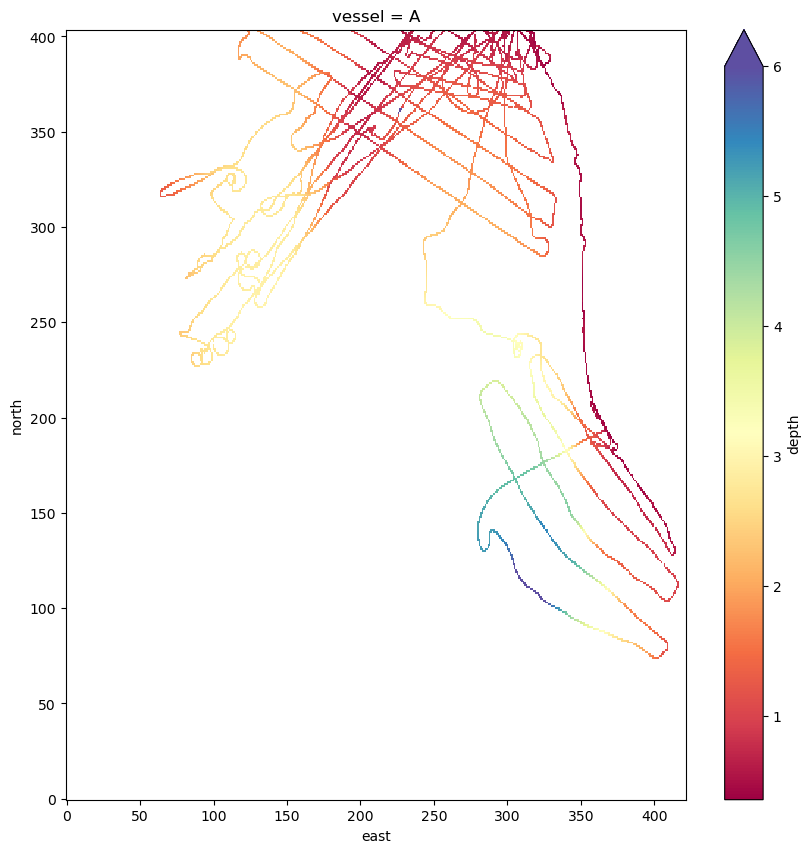

In [30]:
vA2.depth.sel(vessel='A').plot(figsize=(10,10), vmax=6, cmap='Spectral')

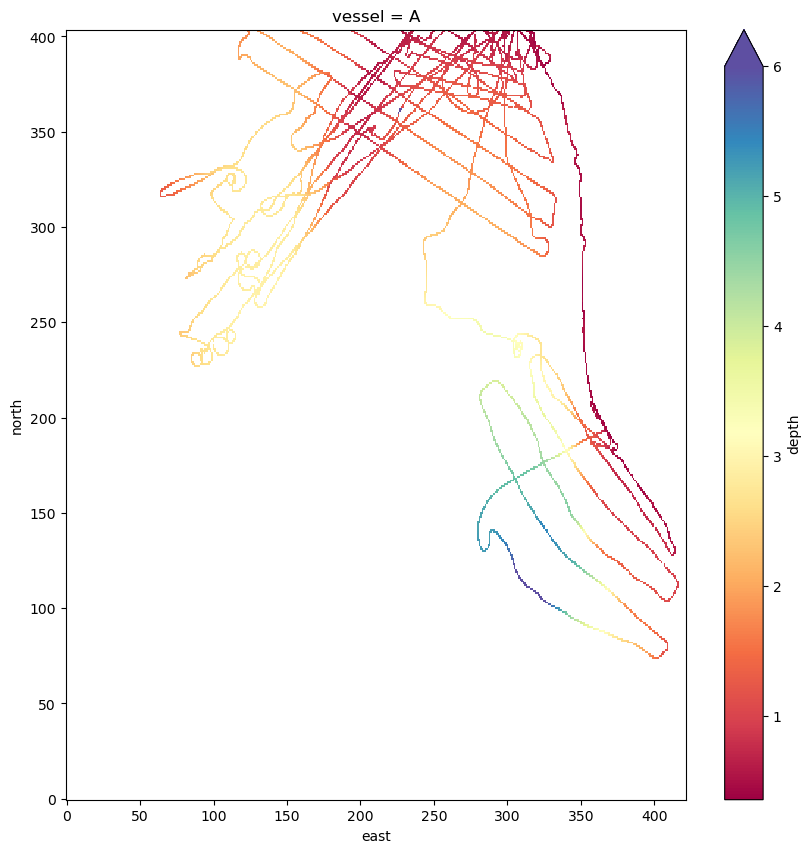

In [26]:
vB2.depth.sel(vessel='A').plot(figsize=(10,10), vmax=6, cmap='Spectral')

In [ ]:
vB2.depth.sel(vessel='B').plot(figsize=(10,10), vmax=6, cmap='Spectral')

In [ ]:
vB2.depth.sel(vessel='B').plot(figsize=(10,10), vmax=6, cmap='Spectral')

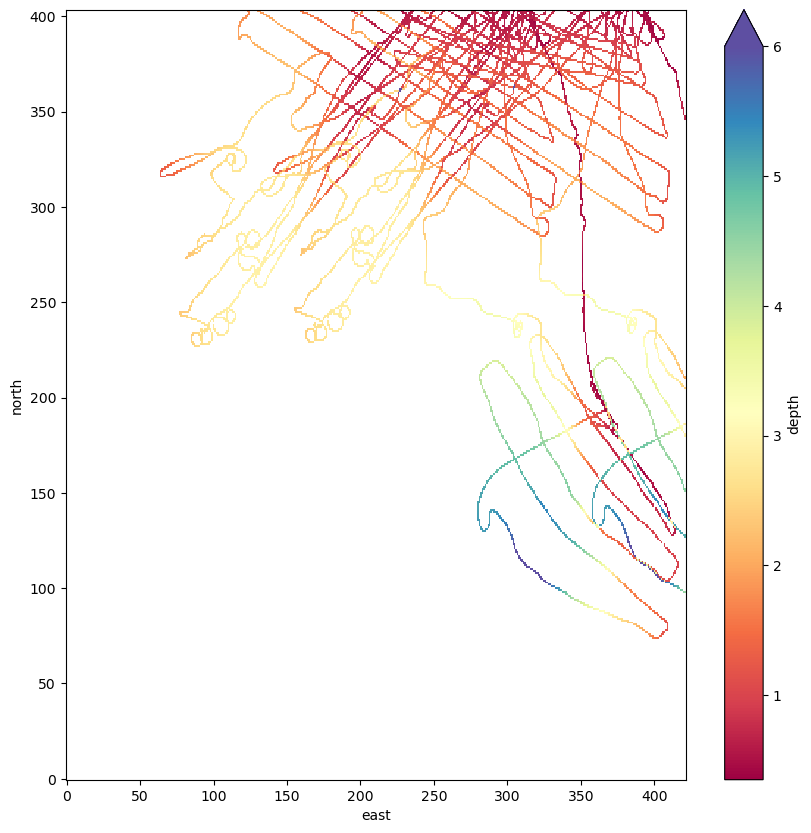

In [31]:
vB2.depth.mean(dim='vessel', skipna=True).plot(figsize=(10,10), vmax=6, cmap='Spectral')